## Predicting Stock Market prices using KNNs

In [38]:
#importing packages
import pandas as pd
import numpy as np
import re
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

# To filter warnings
import warnings
warnings.filterwarnings('ignore')

In [39]:
#for normalizing data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

### Extracting data from dataset

In [40]:
#reading the csv file
data_frame = pd.read_csv('NSE-TATAGLOBAL.csv')

data_frame.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2019-01-04,210.60,214.90,210.00,213.50,213.80,1213181.0,2583.05
1,2019-01-03,214.95,215.35,209.90,210.55,210.05,2096553.0,4433.50
2,2019-01-02,219.00,220.35,213.60,214.20,214.60,1081778.0,2340.31
3,2019-01-01,219.95,221.05,218.05,218.95,219.10,716275.0,1571.63
4,2018-12-31,222.00,223.65,218.85,219.55,219.40,965858.0,2131.09


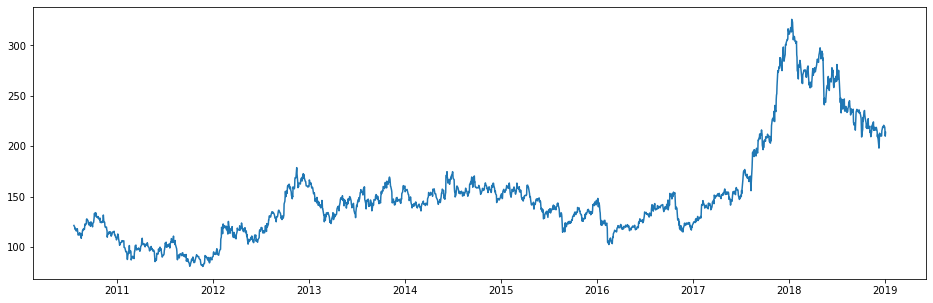

In [41]:
#setting index as date
data_frame['Date'] = pd.to_datetime(data_frame.Date,format='%Y-%m-%d')
data_frame.index = data_frame['Date']

#plotting the closing prices in the stock data
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10
plt.figure(figsize=(16,5))
plt.plot(data_frame['Close'])

### Preprocessing the data and feature extraction

In [42]:
#sorting the dataframe
data = data_frame.sort_index(ascending=True, axis=0)

data.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
Date,,,,,,,,
2010-07-21,2010-07-21,122.1,123.00,121.05,121.10,121.55,658666.0,803.56
2010-07-22,2010-07-22,120.3,122.00,120.25,120.75,120.90,293312.0,355.17
2010-07-23,2010-07-23,121.8,121.95,120.25,120.35,120.65,281312.0,340.31
2010-07-26,2010-07-26,120.1,121.00,117.10,117.10,117.60,658440.0,780.01
2010-07-27,2010-07-27,117.6,119.50,112.00,118.80,118.65,586100.0,694.98


In [43]:
#creating a separate dataset that contains only the date and closing price
new_data = pd.DataFrame(index=range(0,len(data_frame)),columns=['Date', 'Close'])

for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

new_data.head()

,Date,Close
0,2010-07-21 00:00:00,121.55
1,2010-07-22 00:00:00,120.9
2,2010-07-23 00:00:00,120.65
3,2010-07-26 00:00:00,117.6
4,2010-07-27 00:00:00,118.65


Now, we define a helper function called add_datepart that adds columns relevant to a date in the column field_name of the data_frame.

For example if we have a series of dates we can then generate features such as Year, Month, Day, Dayofweek, Is_month_start, etc as shown below:

In [44]:
def add_datepart(data_frame, field_name, drop=True):
    fld = data_frame[field_name]
    if not np.issubdtype(fld.dtype, np.datetime64):
        data_frame[field_name] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', field_name)
    for n in ('Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start'):
        data_frame[targ_pre+n] = getattr(fld.dt,n.lower())
    if drop: data_frame.drop(field_name, axis=1, inplace=True)

In [45]:
add_datepart(new_data, 'Date')
new_data.head()

,Close,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start
0,121.55,2010,7,29,21,2,202,False,False,False,False,False,False
1,120.9,2010,7,29,22,3,203,False,False,False,False,False,False
2,120.65,2010,7,29,23,4,204,False,False,False,False,False,False
3,117.6,2010,7,30,26,0,207,False,False,False,False,False,False
4,118.65,2010,7,30,27,1,208,False,False,False,False,False,False


### We will now split the data into train and validation sets to check the performance of the model.

In [46]:
#split into train and validation
train = new_data[:987]
valid = new_data[987:]

x_train = train.drop('Close', axis=1)
y_train = train['Close']
x_valid = valid.drop('Close', axis=1)
y_valid = valid['Close']

In [47]:
#scaling data
x_train_scaled = scaler.fit_transform(x_train)
x_train = pd.DataFrame(x_train_scaled)
x_valid_scaled = scaler.fit_transform(x_valid)
x_valid = pd.DataFrame(x_valid_scaled)


### Fitting the kNN regression model

In [48]:
#using gridsearch to find the best parameter
parameters = {'n_neighbors':[2,3,4,5,6,7,8,9]}
knn_reg = neighbors.KNeighborsRegressor()
model = GridSearchCV(knn_reg, parameters, cv=5)

#fit the model and make predictions
model.fit(x_train,y_train)
predictions = model.predict(x_valid)

#### Finding the root mean square error value and R squared

In [49]:
#rmse
rms=np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(predictions)),2)))
rms


66.48661330665911

In [50]:
from sklearn.metrics import r2_score
r2_score(np.array(y_valid),np.array(predictions))

-0.48013748382777854

The R squared value is negative, the chosen model does not follow the trend of the data, so  fits worse than a horizontal line.

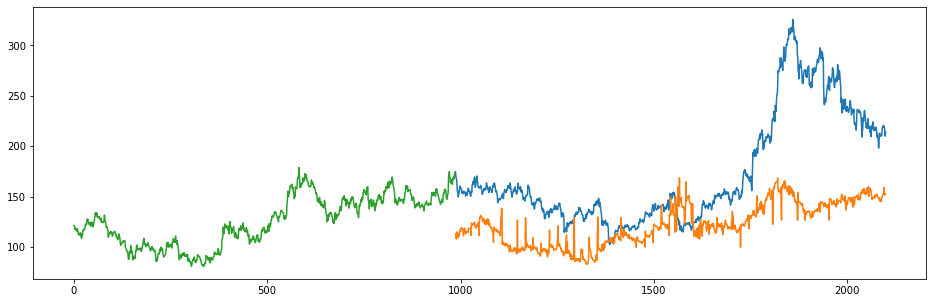

In [51]:
#plotting the predicted values 
valid['Predictions'] = 0
valid['Predictions'] = predictions
plt.figure(figsize=(16,5))
plt.plot(valid[['Close', 'Predictions']])
plt.plot(train['Close'])